### Example of using the MAML implementation to learn 5-way 5-shot tasks on the Omniglot dataset

In this notebook, we demonstrate the use of the MAML implemenation from `tensorflow-fewshot`. We use the Omniglot dataset as an example, and we aim to replicate the results claimed in the paper that introduced MAML: *Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks* (Finn et al., 2017).

## Imports

In [1]:
from tensorflow_fewshot.models import MAML
import tensorflow_fewshot.models.utils as utils
from tensorflow_fewshot.datasets import MetaDatasetFromArray

In [2]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow_datasets as tfds

from IPython.display import display, clear_output

# Dataset

In [3]:
# Load Omniglot using tensorflow datasets. It provides standard train/test splits out of the box.
train_ds = tfds.load("omniglot", split=tfds.Split.TRAIN, batch_size=-1)
################################
# We construct the actual training set by taking the first channel (they are all equal), resizing
# the images to 28x28, and inverting the colors so that the actual signal is positive while black
# pixels are zeroed out. Finally we rescale the image to the range [0, 1] for numerical stability.
# The resulting dataset is then augmented with 90°, 180° and 270° rotations.
#
# Downscaling is important, otherwise the network isn't powerful enough to train
################################
omniglot_X = tfds.as_numpy(train_ds)['image'].astype(np.float32)
train_X = np.zeros((4 * omniglot_X.shape[0], 28, 28, 1), dtype=np.float32)
train_Y = tfds.as_numpy(train_ds)['label']
train_Y = np.tile(train_Y, 4) + np.repeat([0, 1, 2, 3], train_Y.shape[0]) * np.max(train_Y)
resize_batch_size = 256
# Batch transformation
for i in range(omniglot_X.shape[0] // resize_batch_size):
    if i % 1 == 0:
        clear_output(wait=True)
        display('resize + grayscale: ' + str(i * 100 // (omniglot_X.shape[0] // resize_batch_size)) + '%')
    train_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, :] = resize(
        (
            (255 - omniglot_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, 0])/255
        )[:, :, :, None],
        (resize_batch_size, 28, 28, 1)
    )

# Remaining elements
train_X[-(omniglot_X.shape[0] % resize_batch_size): :, :, :] = resize(
        (
            (255 - omniglot_X[-(omniglot_X.shape[0] % resize_batch_size):, :, :, 0])/255
        )[:, :, :, None],
        (omniglot_X.shape[0] % resize_batch_size, 28, 28, 1))

# Adding all 4 rotations to training data
for i in range(omniglot_X.shape[0] // resize_batch_size):
    clear_output(wait=True)
    display('rotations ' + str(i * 100 // (omniglot_X.shape[0] // resize_batch_size)) + '%')
    for rot in [1, 2, 3]:
        train_X[
            omniglot_X.shape[0] * rot + i * resize_batch_size:
            omniglot_X.shape[0] * rot + (i + 1) * resize_batch_size,
            :, :, :
        ] = np.rot90(train_X[
                     i * resize_batch_size:(i + 1) * resize_batch_size, :, :, :
                     ], rot, (1, 2))
for rot in [1, 2, 3]:
    train_X[
        rot * omniglot_X.shape[0] - (omniglot_X.shape[0] % resize_batch_size):rot * omniglot_X.shape[0],
        :, :, :
    ] = np.rot90(train_X[
                     - (omniglot_X.shape[0] % resize_batch_size):, :, :, :
                 ], rot, (1, 2))

# Apply the same transformations to the test set
test_ds = tfds.load("omniglot", split=tfds.Split.TEST, batch_size=-1)
omniglot_test_X = tfds.as_numpy(test_ds)['image'].astype(np.float32)
test_X = np.zeros((omniglot_test_X.shape[0], 28, 28, 1), dtype=np.float32)
test_Y = tfds.as_numpy(test_ds)['label']
for i in range(test_X.shape[0] // resize_batch_size):
    if i % 1 == 0:
        clear_output(wait=True)
        display('Test set ' + str(i * 100 // (test_X.shape[0] // resize_batch_size)) + '%')
    test_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, :] = resize(
        (
            (255 - omniglot_test_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, 0])/255
        )[:, :, :, None],
        (resize_batch_size, 28, 28, 1))

test_X[-(omniglot_test_X.shape[0] % resize_batch_size): :, :, :] = resize(
        (
            (255 - omniglot_test_X[-(omniglot_test_X.shape[0] % resize_batch_size):, :, :, 0])/255
        )[:, :, :, None],
        (omniglot_test_X.shape[0] % resize_batch_size, 28, 28, 1))

# Display the split
print("Train X shape:", train_X.shape)
print("Train Y shape:", train_Y.shape)
print("Test X shape:", test_X.shape)
print("Test Y shape:", test_Y.shape)

'Test set 98%'

Train X shape: (77120, 28, 28, 1)
Train Y shape: (77120,)
Test X shape: (13180, 28, 28, 1)
Test Y shape: (13180,)


Exemples de classes, avec 5 représentants chacune


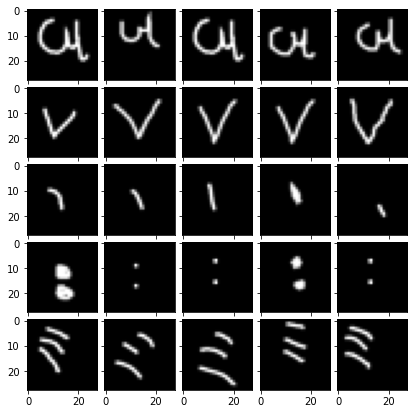

In [4]:
# Display the dataset on a Grid
# np.random.choice(class_name, 5)
classes_to_draw = [453, 837, 278, 192, 625]
indices_to_draw = []
for class_id in classes_to_draw:
    class_indices = np.array(
    list(filter(lambda elem: elem[1] == class_id, enumerate(train_Y)))
    )
    chosen_examples_indices = np.random.choice(range(len(class_indices)), 5)
    indices_to_draw.extend(class_indices[chosen_examples_indices,:])

fig = plt.figure(figsize=(7., 7.))
print("Exemples de classes, avec 5 représentants chacune")
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(len(classes_to_draw), 5),
    axes_pad=0.1,
)

for ax, im in zip(grid, indices_to_draw):
    # Iterating over the grid returns the Axes.
    ax.imshow(train_X[im[0],:,:,0], cmap='gray')

Here, each task corresponds to the classification of a limited set of characters. We will use 5 of them in the rest of this notebook. We thus talk about 5-way classification.
The model will be meta-trained on randomly-generated 5-way classification tasks, and then evaluated on tasks sampled from **unseen** characters (from the test set).

In [5]:
meta_ds = MetaDatasetFromArray(train_X, train_Y)

# Meta-training

The base model we will be using is one proposed by Vinyals et al. in their 2016 paper "Matching Networks for One Shot Learning".

In [6]:
encoder = utils.create_imageNetCNN(input_shape=(28, 28, 1), use_dense_head=True, output_dim=5)

In [7]:
model = MAML(encoder, tf.keras.losses.categorical_crossentropy)

In [14]:
n_way = 5
ks_shot = 5
kq_shot = 5
n_episode = 200 # Try with at least 10000 episodes for interesting results
n_task = 5
alpha = 1e-2
learning_rate = 1e-3

def task_generator(ds, n_task):
    for i_task in range(n_task):
        yield ds.get_one_episode(n_way=n_way, ks_shot=ks_shot, kq_shot=kq_shot, one_hot_encode=True)

def episode_end_callback(**kwargs):
    n_episode = kwargs['episode']
    if n_episode%5 == 0:
        epi_loss = np.mean(kwargs['episode_loss'].numpy())
        print("At episode", n_episode, "episode loss is", epi_loss)

model.meta_train(
    lambda : task_generator(meta_ds, n_task),
    n_episode=n_episode,
    alpha=alpha,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    episode_end_callback=episode_end_callback
)

At episode 0 episode loss is 8.000503
At episode 5 episode loss is 7.8128242
At episode 10 episode loss is 7.7671757
At episode 15 episode loss is 7.5955753
At episode 20 episode loss is 7.3279085
At episode 25 episode loss is 7.486969
At episode 30 episode loss is 7.2280293
At episode 35 episode loss is 6.911141
At episode 40 episode loss is 7.0583253
At episode 45 episode loss is 6.5435185
At episode 50 episode loss is 6.687035
At episode 55 episode loss is 6.2118006
At episode 60 episode loss is 5.5587535
At episode 65 episode loss is 5.789961
At episode 70 episode loss is 5.6104517
At episode 75 episode loss is 4.7323103
At episode 80 episode loss is 5.383997
At episode 85 episode loss is 5.4056063
At episode 90 episode loss is 5.471928
At episode 95 episode loss is 4.660933
At episode 100 episode loss is 4.687304
At episode 105 episode loss is 4.715231
At episode 110 episode loss is 3.9415927
At episode 115 episode loss is 4.4548774
At episode 120 episode loss is 5.068682
At episo

## Example of fine-tuning and prediction
This section was run using a model trained for 6700 episodes. Re-executing the cells below with a model trained for only 200 episodes will likely make predictions close to random.

In [8]:
# model.model = tf.keras.models.load_model("MAML_Omniglot_6700_episodes.h5")

In [9]:
test_ds = MetaDatasetFromArray(test_X, test_Y)

In [10]:
fit_data, test_data = test_ds.get_one_episode(n_way=5, ks_shot=5, kq_shot=5, one_hot_encode=True)
fit_images, fit_labels = fit_data
test_images, test_labels = test_data

In [11]:
finetuned_model = model.fit(fit_images, fit_labels)

In [12]:
predictions = np.argmax(finetuned_model.predict(test_images), axis=1)
argmax_test_labels = np.argmax(test_labels, axis=1)

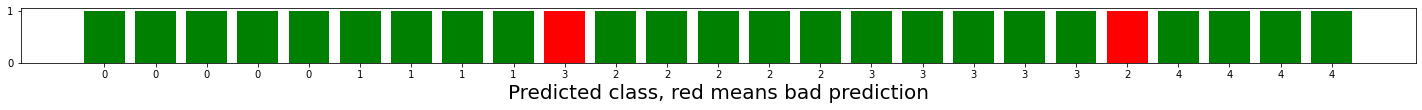

In [13]:
plt.figure(figsize=(25, 1))
plt.bar(np.arange(len(test_data[1])), (predictions==argmax_test_labels).astype(np.int), color='g', tick_label=predictions)
plt.bar(np.arange(len(test_data[1])), (predictions!=argmax_test_labels).astype(np.int), color='r', tick_label=predictions)
plt.xlabel("Predicted class, red means bad prediction", size=20);

## Evaluation

In [14]:
n_task = 100

acc = []
for i_task in range(n_task):
    clear_output(wait=True)
    display("Evaluation task "+str(i_task+1)+" out of "+str(n_task))
    train_set, eval_set = test_ds.get_one_episode(n_way=5, ks_shot=5, kq_shot=5, one_hot_encode=True)
    finetuned_model = model.fit(train_set[0], train_set[1])
    eval_preds = np.argmax(finetuned_model(eval_set[0]), axis=1)
    acc.append(np.mean(np.argmax(eval_set[1], axis=1) == eval_preds))

'Evaluation task 100 out of 100'

In [15]:
mean_acc = np.mean(acc)
var = np.var(acc)
ic95 = 1.96*np.sqrt(var/n_task)
print("Accuracy on", n_task, "randomly sampled tasks is", str(round(mean_acc*100, 2))+"%", "+/-", round(ic95*100, 2))

Accuracy on 100 randomly sampled tasks is 95.76% +/- 1.23
